In [1]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

Using TensorFlow backend.


0


In [2]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback
from keras.layers import CuDNNLSTM
from keras.regularizers import L1L2
import keras.backend as K
import gc

In [3]:
train_df = pd.read_csv("./input/train.csv")

print("Train shape : ",train_df.shape)


Train shape :  (1306122, 3)


In [4]:
## Config values 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2019)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2020)
print("Validation shape : ",val_df.shape)
print("Test shape : ",test_df.shape)
embed_size = 300 # how big is each word vector
max_features = 70000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
val_df["question_text"] = val_df["question_text"].apply(lambda x: clean_text(x))

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
oov_tok = "OOV_TOK"
tokenizer = Tokenizer(num_words=max_features) # lower = False, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen, truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post')

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values
del train_df, val_df, test_df
gc.collect()

Validation shape :  (130612, 3)
Test shape :  (130613, 3)


7

In [5]:
EMBEDDING_FILE = './input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [6]:
regularizer = L1L2(l1=0.0, l2=0.001)
def get_model():
    K.clear_session() 
    inp = Input(shape=(maxlen,))
    emb_out = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    lstm_out = Bidirectional(CuDNNLSTM(64, return_sequences=True))(emb_out)
    gmp_out = GlobalMaxPool1D()(lstm_out)
    d_out = Dense(16, activation="relu")(gmp_out)
    drop_out = Dropout(0.1)(d_out)
    d_out = Dense(1, activation="sigmoid")(drop_out)
    model = Model(inputs=inp, outputs=d_out)
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    print(model.summary())
    return(model)

model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           21000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           187392    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)  

In [7]:
# Define callback function if detailed log required

class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []
        for keys in logs:
           print(keys) 

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    #Store val_acc/loss per batch    
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))
        
# Compute class_weights for imbalanced train set
def compute_class_weight(input_list):

  class_weights = class_weight.compute_class_weight('balanced', 
                                                   np.unique(input_list),  
                                                   input_list)
                                                   
  return(class_weights)                                                   
        
#define callback functions
history = History()
callbacks = [history]        

class_weights = compute_class_weight(train_y)

class_weights[1] *= 10
print(class_weights)

[ 0.53290517 80.97591407]


In [8]:

model.fit(train_X, train_y, 
          batch_size=512, 
          epochs=2, 
          validation_data=(val_X, val_y), 
          class_weight = class_weights,
          callbacks= callbacks)
model.save_weights('./output/model_glove_weights.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1044897 samples, validate on 130612 samples
Epoch 1/2
1044897/1044897 [==============================] - 42s 40us/step - loss: 0.1137 - acc: 0.9556 - val_loss: 0.1050 - val_acc: 0.9586
Epoch 2/2
1044897/1044897 [==============================] - 38s 37us/step - loss: 0.1005 - acc: 0.9602 - val_loss: 0.1037 - val_acc: 0.9593


In [9]:
#from tensorflow.keras.models import Model, load_model

#model.load_weights('./output/model_glove_weights.h5')
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

130612/130612 [==============================] - 2s 12us/step
F1 score at threshold 0.1 is 0.6395809739524349
F1 score at threshold 0.11 is 0.6462191358024691
F1 score at threshold 0.12 is 0.6497397112267951
F1 score at threshold 0.13 is 0.6518022296655502
F1 score at threshold 0.14 is 0.6548024609752376
F1 score at threshold 0.15 is 0.6580006190034046
F1 score at threshold 0.16 is 0.6607749830047588
F1 score at threshold 0.17 is 0.6620419402668927
F1 score at threshold 0.18 is 0.6644860314225964
F1 score at threshold 0.19 is 0.6650406504065041
F1 score at threshold 0.2 is 0.6669591445023306
F1 score at threshold 0.21 is 0.66751705396262
F1 score at threshold 0.22 is 0.6672649764415526
F1 score at threshold 0.23 is 0.6672334636966503
F1 score at threshold 0.24 is 0.6686106346483706
F1 score at threshold 0.25 is 0.6690124596215966
F1 score at threshold 0.26 is 0.6675596971461852
F1 score at threshold 0.27 is 0.6669409828356454
F1 score at threshold 0.28 is 0.6662315314780751
F1 score at

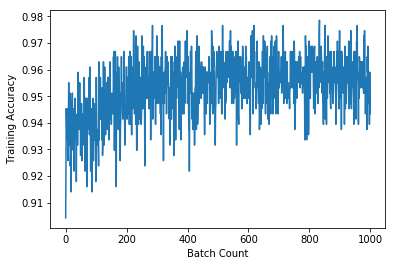

In [10]:
x = range(len(history.train_acc))
%matplotlib inline
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Accuracy')
plt.plot(x[0:1000], history.train_acc[0:1000])
plt.show()
#fig.savefig('glove_emb_accuracy')

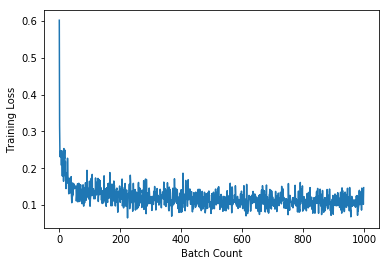

In [11]:
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Loss')
plt.plot(x[0:1000], history.train_loss[0:1000])
plt.show()
#fig.savefig('glove_emb_loss')

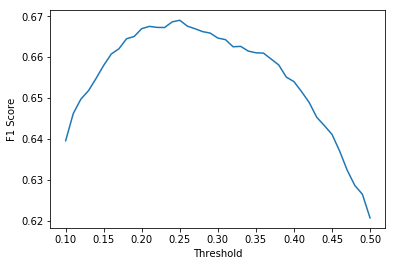

In [12]:

%matplotlib inline
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
#fig.savefig('self_train_emb_F1_score')

In [14]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
f1_max = 0
opt_thresh = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(test_y, (pred_test_y>thresh).astype(int))
    if(f1_score > f1_max):
        f1_max = f1_score
        opt_thresh = thresh
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

pred = [int(a > opt_thresh) for a in pred_test_y]    

130613/130613 [==============================] - 1s 10us/step
F1 score at threshold 0.1 is 0.6406081366430482
F1 score at threshold 0.11 is 0.6472504311170721
F1 score at threshold 0.12 is 0.6520932955987118
F1 score at threshold 0.13 is 0.65574909433775
F1 score at threshold 0.14 is 0.6589280306853739
F1 score at threshold 0.15 is 0.6594849697342772
F1 score at threshold 0.16 is 0.6628173116937163
F1 score at threshold 0.17 is 0.664242807461271
F1 score at threshold 0.18 is 0.6669156086631816
F1 score at threshold 0.19 is 0.6696177931332326
F1 score at threshold 0.2 is 0.6715798667976853
F1 score at threshold 0.21 is 0.6733219348077878
F1 score at threshold 0.22 is 0.6741372581814127
F1 score at threshold 0.23 is 0.675014100394811
F1 score at threshold 0.24 is 0.6750256468710817
F1 score at threshold 0.25 is 0.6739180478821363
F1 score at threshold 0.26 is 0.6739016888166677
F1 score at threshold 0.27 is 0.673345049794962
F1 score at threshold 0.28 is 0.6726155300791867
F1 score at th

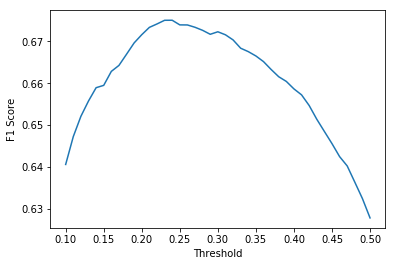

In [15]:
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
#fig.savefig('glove_emb_F1_score')

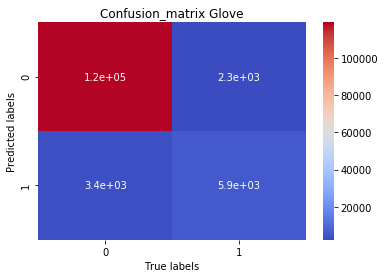

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import seaborn as sns
def get_confusion_matrix(val_y, pred,title):
    cm=confusion_matrix(pred,val_y)
   
    fig = plt.figure()
    sns.heatmap(cm, cmap='coolwarm', annot=True)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
    #fig.savefig('glove_confusion_matrix')
 
get_confusion_matrix(test_y,pred,'Confusion_matrix Glove')    

In [19]:
from sklearn.metrics import recall_score, precision_score
r = recall_score(test_y, pred, average='binary')
p = precision_score(test_y, pred, average='binary')
print('Precision: {:.3f} Recall: {:.3f}'.format(p, r))

#fig.savefig('glove_ROC')

Precision: 0.633 Recall: 0.723
